# Compare Value
- i counted 73 rings in total of the whole tree --> so he is 73 years old

## Get the rough shape

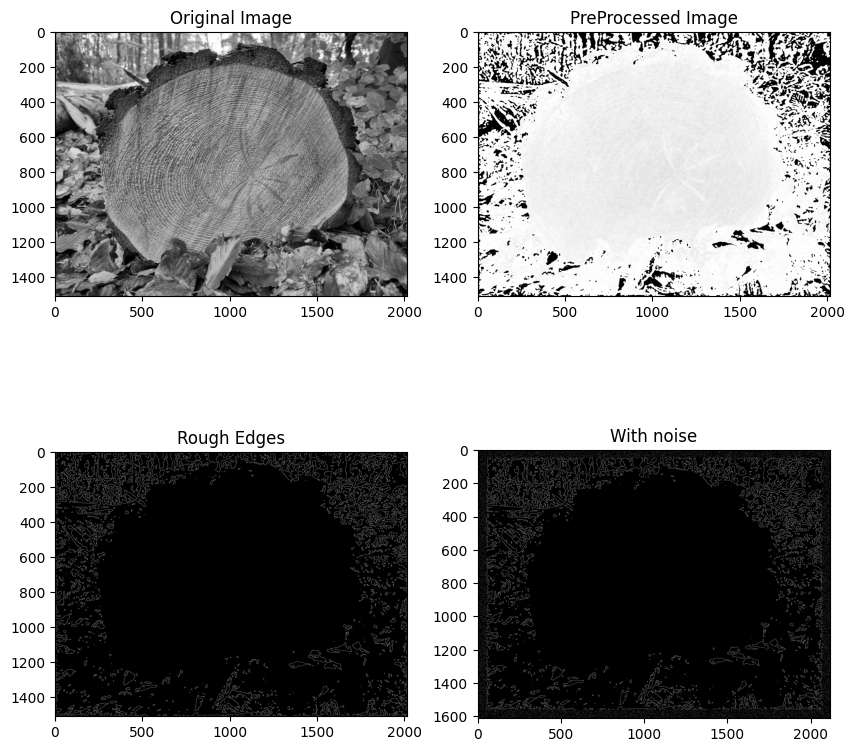

In [95]:
import matplotlib.pyplot as plt
import matplotlib.image as pltimg
import numpy as np
import skimage.filters as filt
import imutils
from PIL import Image
from skimage.morphology import reconstruction
import scipy.ndimage as nd
import cv2 as cv

# load image
img = pltimg.imread("./input.tif")
# load original image
fig,ax =plt.subplots(2,2,figsize=(10,10))
ax[0][0].imshow(img,cmap=plt.get_cmap('gray'))
ax[0][0].title.set_text("Original Image")
# show image
image = cv.Laplacian(img,cv.CV_32F)
seed = np.copy(image)
seed[3:-3, 3:-3] = image.min()
mask = image
dilated = reconstruction(seed, mask, method='dilation')
# make gaussian to blur the inside of the image
gaussianOfDilated = np.uint8(filt.gaussian(dilated,sigma=(3,3),truncate=3,channel_axis=2))
ax[0][1].imshow(gaussianOfDilated,cmap=plt.get_cmap('gray'))
ax[0][1].title.set_text("PreProcessed Image")
# detect edges to see the rough shape of the tree trunc
edges = cv.Canny(gaussianOfDilated, 100, 200)
ax[1][0].imshow(edges,cmap=plt.get_cmap('gray'))
ax[1][0].title.set_text("Rough Edges")

image = np.zeros(shape=(img.shape[0]+100,img.shape[1]+100),dtype=np.uint8)
# make black and white noise image
x = np.random.randint(0, image.shape[1] - 1, int(0.05 * image.size))
y = np.random.randint(0, image.shape[0] - 1, int(0.05 * image.size))
image[y, x] = 255

image[50:-50,50:-50] = edges
ax[1][1].imshow(image,cmap=plt.get_cmap('gray'))
ax[1][1].title.set_text("With noise")

plt.show()

# Approximated Mask by filling everything out that is not the tree

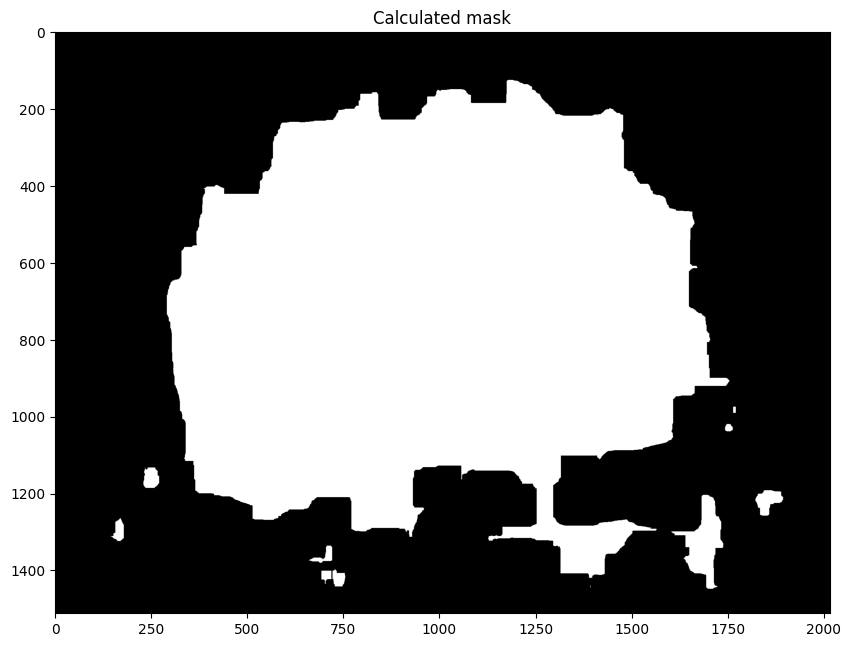

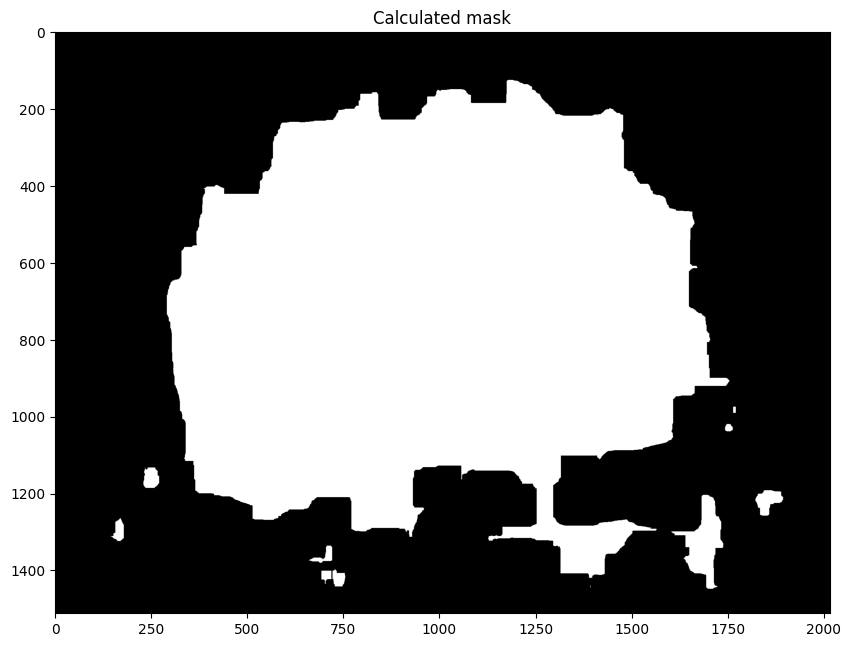

In [96]:
targetImage = np.zeros(img.shape,dtype=np.uint8)
# this functions checks whether there are 20 white pixels because the tree shape is not shown in the tree --> so we can roughly extract the tree trunc
def fill_roughly(x,y):
    subimage= image[x:x+100,y:y+100]
    left = subimage[0:50]
    right =subimage[50:100]
    top  = subimage[0:100,0:50]
    bottom = subimage[0:100,50:100]
    countleft = np.count_nonzero(left == 255)
    countright = np.count_nonzero(right == 255)
    counttop = np.count_nonzero(top == 255)
    countbottom = np.count_nonzero(bottom == 255)
    relHor = abs((countleft-countright)/50)
    relVer = abs((counttop-countbottom)/50)
    if (relHor<0.7 or relVer<0.7) and countbottom+counttop<30:
        return True
    else:
        return False
for x in range(edges.shape[0]):
    for y in range(edges.shape[1]):
        if fill_roughly(x,y):
            targetImage[x,y] = 255

fig,ax =plt.subplots(1,1,figsize=(10,10))
ax.imshow(targetImage,cmap=plt.get_cmap('gray'))
ax.title.set_text("Calculated mask")
plt.show()

# Approximate the middle point
- is very inaccurate because the maske isnt circular and it only assumes the widest point --> i failed to create a bizure curve approximation --> so it took the widest points
- is under the assumption t hat the tree is the thickest around the middle point
- calculate the lines for later use

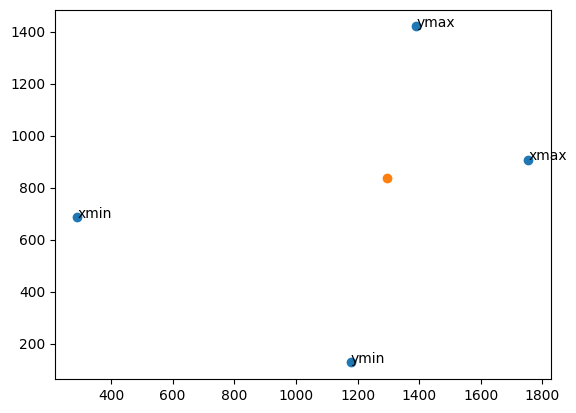

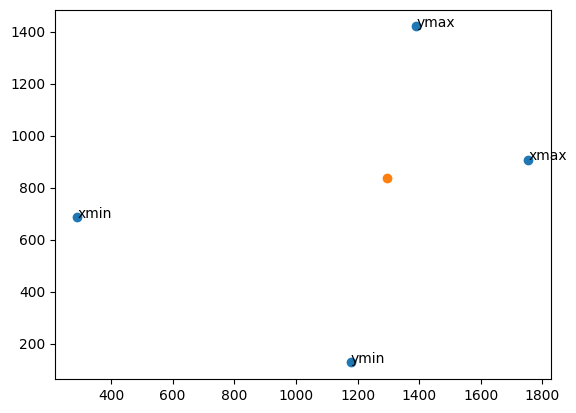

In [97]:

contours = cv.findContours(targetImage.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_NONE)
cnts = imutils.grab_contours(contours)
c = max(cnts, key=cv.contourArea)
# get all points
xs = c[:, 0, 0]
ys = c[:, 0, 1]
# get the maximas of each to draw lines and get the middle point --> whith this assume the middle point
ymax = np.amax(ys)
index = np.where(ys == ymax)
ymax = np.array([xs[index][0], ymax])

ymin = np.amin(ys)
index = np.where(ys == ymin)
ymin = np.array([xs[index][0], ymin])

xmax = np.amax(xs)
index = np.where(xs == xmax)
xmax = np.array([xmax, ys[index][0]])

xmin = np.amin(xs)
index = np.where(xs == xmin)
xmin = np.array([xmin, ys[index][0]])

# calculate intersection
def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b
# segment intersect and calulate with numpy --> performance
def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db + b1
# show intersects
xIntersec,yIntersec = seg_intersect(xmin,xmax,ymin,ymax)
points = np.array([xmin,xmax,ymin,ymax])
n = ["xmin","xmax","ymin","ymax"]
plt.scatter(points[:,0],points[:,1])
for i, txt in enumerate(n):
        plt.annotate(txt, (points[i][0], points[i][1]))
plt.scatter(xIntersec,yIntersec)
plt.show()

## Extrams pointed on the Masked tree

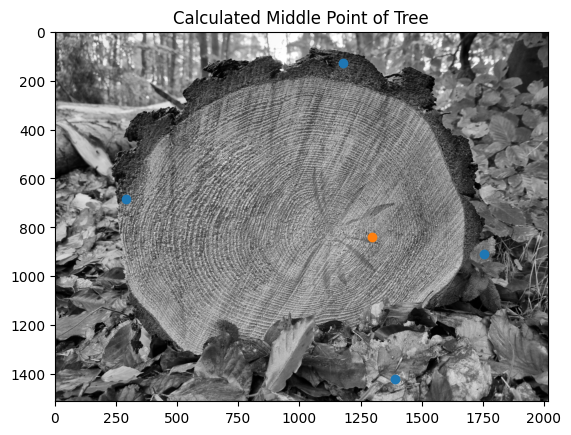

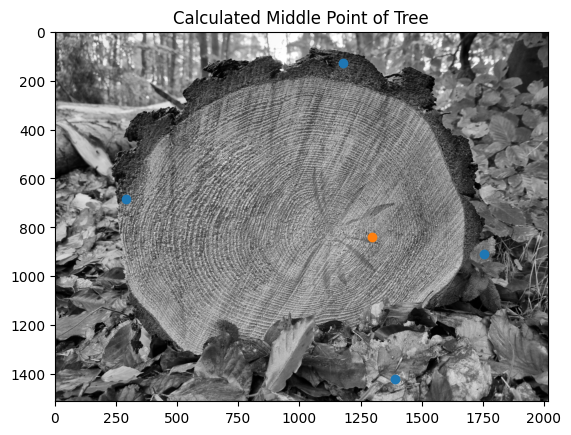

In [98]:
plt.gray()
plt.imshow(img)
plt.scatter(points[:,0],points[:,1])
plt.scatter(xIntersec,yIntersec)
plt.title("Calculated Middle Point of Tree")
plt.show()


- the algorithm copied from the internet to extract pixcels along a line represented by two points

In [99]:
# löine iterator that checks the iteration

def createLineIterator(P1, P2, img):
    """
    Produces and array that consists of the coordinates and intensities of each pixel in a line between two points

    Parameters:
        -P1: a numpy array that consists of the coordinate of the first point (x,y)
        -P2: a numpy array that consists of the coordinate of the second point (x,y)
        -img: the image being processed

    Returns:
        -it: a numpy array that consists of the coordinates and intensities of each pixel in the radii (shape: [numPixels, 3], row = [x,y,intensity])
    """
    #define local variables for readability
    imageH = img.shape[0]
    imageW = img.shape[1]
    P1X = P1[0]
    P1Y = P1[1]
    P2X = P2[0]
    P2Y = P2[1]

    #difference and absolute difference between points
    #used to calculate slope and relative location between points
    dX = P2X - P1X
    dY = P2Y - P1Y
    dXa = np.abs(dX)
    dYa = np.abs(dY)

    #predefine numpy array for output based on distance between points
    itbuffer = np.empty(shape=(np.maximum(dYa, dXa), 3), dtype=np.float32)
    itbuffer.fill(np.nan)

    #Obtain coordinates along the line using a form of Bresenham's algorithm
    negY = P1Y > P2Y
    negX = P1X > P2X
    if P1X == P2X:  #vertical line segment
        itbuffer[:, 0] = P1X
        if negY:
            itbuffer[:, 1] = np.arange(P1Y - 1, P1Y - dYa - 1, -1)
        else:
            itbuffer[:, 1] = np.arange(P1Y + 1, P1Y + dYa + 1)
    elif P1Y == P2Y:  #horizontal line segment
        itbuffer[:, 1] = P1Y
        if negX:
            itbuffer[:, 0] = np.arange(P1X - 1, P1X - dXa - 1, -1)
        else:
            itbuffer[:, 0] = np.arange(P1X + 1, P1X + dXa + 1)
    else:  #diagonal line segment
        steepSlope = dYa > dXa
        if steepSlope:
            slope = dX.astype(np.float32) / dY.astype(np.float32)
            if negY:
                itbuffer[:, 1] = np.arange(P1Y - 1, P1Y - dYa - 1, -1)
            else:
                itbuffer[:, 1] = np.arange(P1Y + 1, P1Y + dYa + 1)
            itbuffer[:, 0] = (slope * (itbuffer[:, 1] - P1Y)).astype(np.int) + P1X
        else:
            slope = dY.astype(np.float32) / dX.astype(np.float32)
            if negX:
                itbuffer[:, 0] = np.arange(P1X - 1, P1X - dXa - 1, -1)
            else:
                itbuffer[:, 0] = np.arange(P1X + 1, P1X + dXa + 1)
            itbuffer[:, 1] = (slope * (itbuffer[:, 0] - P1X)).astype(np.int) + P1Y

    #Remove points outside of image
    colX = itbuffer[:, 0]
    colY = itbuffer[:, 1]
    itbuffer = itbuffer[(colX >= 0) & (colY >= 0) & (colX < imageW) & (colY < imageH)]

    #Get intensities from img ndarray
    itbuffer[:, 2] = img[itbuffer[:, 1].astype(np.uint), itbuffer[:, 0].astype(np.uint)]

    return itbuffer

# Counting the white pixels
- is under the assumption that the white pixels are only one width wide

Rings:
78


C:\Users\Tilmann\AppData\Local\Temp\ipykernel_9748\3036957721.py:64: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  itbuffer[:, 1] = (slope * (itbuffer[:, 0] - P1X)).astype(np.int) + P1Y
C:\Users\Tilmann\AppData\Local\Temp\ipykernel_9748\3036957721.py:57: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review y

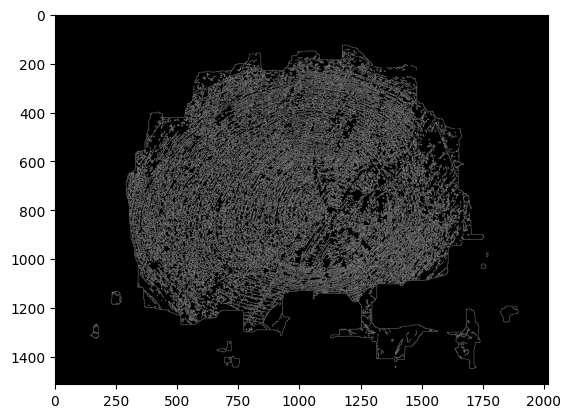

In [101]:
maskedImage = cv.bitwise_and(img,img,mask=targetImage)
img_blur = cv.GaussianBlur(maskedImage, (5,5), 0)
edges = cv.Canny(img_blur, 100, 200)


def countedWhitePixels(lineHor):
    count = 0
    li = createLineIterator(lineHor[0], lineHor[1],edges)

    for (r, g, b) in li:
        if b:
            count += 1
    return count

countedHor = countedWhitePixels((xmin,xmax))

countedver = countedWhitePixels((ymin,ymax))
print("Rings:")
# divided by 4 because we get over thw whole line --> meaning double the rings and every change is calculated so
# if it is fgrom black to white and vise versa it counts as one so we have oduble the change
# then we bild the mid around 4
print(int((countedver/4+countedHor/4)/2))

plt.imshow(edges)